Este *notebook* representa um pouco do estudo de ciência de dados a partir [deste *dataset*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) do Kaggle. A maior parte do que aprendi foi baseado na explicação adquirida a partid [deste *notebook*](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook). Muitos conceitos são explorados neste *notebook*, alguns sendo de estatística, outros de aprendizado de máquina e inteligência artificial. Alguns *insights* também são tirados a partir do meu conhecimento teórico que adquiri na minha graduação de Ciência da Computação.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,6]
sns.set(style="darkgrid")

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [3]:
X = pd.read_csv('train.csv')

In [4]:
train_ID = X['Id']

X.drop('Id', axis = 1, inplace = True)

## Funções que serão necessárias durante o código


In [5]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))

    if(all(isinstance(n, not str)) for n in unique_list):
        
        unique_list = [item for item in unique_list if not(pd.isnull(item)) == True]
    
    return unique_list, len(unique_list)

def counterElements(lista):

    auxLista, _ = unique(lista)

    dicio = dict.fromkeys(auxLista, 0)
    dicio['NaN'] = 0

    for i, value in enumerate(auxLista):
        
        counter = 0

        for j in range(len(lista)):

            if lista[j] == auxLista[i]:

                counter += 1
    
        dicio[value] = counter

    dicio['NaN'] = lista.isna().sum()

    return dicio

def createColumnsWNaN(lista):

    totalSum = 0
    columnsWNaN = []

    #keys = X.keys()

    for column in lista:
        
        nullElements = X[column].isnull().sum()

        if(nullElements):
            columnsWNaN.append(column)
            totalSum+=1

    if(totalSum > 1):

        print('There are {} relevant columns in with one or more "NaN" as values: {}'.format(totalSum, columnsWNaN))

    else:
        print('There is 1 relevant column in with one or more "NaN" as values: {}'.format(columnsWNaN))

    return columnsWNaN

def createPercentageOfMissingValues(lista):
    percentColumnWNaN = {}
    totalColumnWNan = {}

    for column in lista:

        percentColumnWNaN[column] = (X[column].isnull().sum() / len(X[column])) * 100
        totalColumnWNan[column] = X[column].isnull().sum()

    dfPercent = pd.DataFrame(list(percentColumnWNaN.items()), columns = ['Feature', 'Faltantes %'])

    dfPercent['Faltantes Total'] = dfPercent['Feature'].map(totalColumnWNan)

    dfPercent = dfPercent.sort_values(by = ['Faltantes %'], ascending = False)

    return dfPercent

def createHistPlot(feature):

    mean = feature.mean()
    median = feature.median()

    plt.axvline(mean, color = 'r', linestyle = '-')
    plt.axvline(median, color = 'g', linestyle = '-')

    sns.histplot(feature, kde = True)

    print('Assimetria: {}'.format(feature.skew()))

    print('Curtose: {}'.format(feature.kurt()))

    plt.legend({'Média': mean,'Mediana': median})

def createProbPlot(feature):
    stats.probplot(feature, plot=plt)


## Informações da saída do dataset 

Com essas informações, pode-se montar o histograma para a análise dos dados. Algo importante para se ter em conta é que não existe o valor 0 nesse *output*, que atrapalharia o modelo regressor, nada que não pudesse ser tratado, como é explicado em [*Medium, Zero-Inflated Regression*](https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af).

In [6]:
print(X['SalePrice'].describe())

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64


## Criando um *heatmap* 
Com o *heatmap*, pode-se analisar como as categorias se relacionam. Quanto mais próximo do vermelho, mais a correlação de categorias é diretamente proporcional. De outra forma, as correlações próximas do azul escuro representam catgegorias inversamente proporcionais se relacionando. Correlações próximas do cinza representam como as categorias não se influenciam. A categoria-alvo que o modelo predirá é *SalePrice*, que representa o valor de venda de uma casa.  

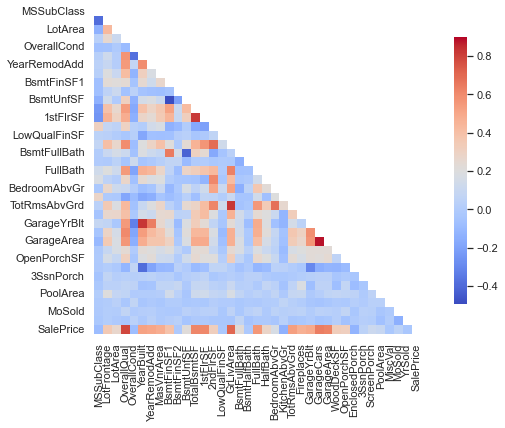

In [7]:
correlation = X.corr()

mask = np.zeros_like(correlation)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):

    f, ax = plt.subplots()

    sns.heatmap(correlation, mask = mask, ax = ax, cbar_kws = {'shrink' : .82},
                vmax = .9, cmap = 'coolwarm', square = True)

## Deletando colunas com valores faltantes

Deve-se deletar o que não for útil para o modelo regressor utilizar para gerar o resultado, e qualquer coluna com mais que 15% de elementos não preenchidos, não é necessário.

In [8]:
columns = X.columns.tolist()

dfPercent = createPercentageOfMissingValues(columns)

print(dfPercent)

        Feature  Faltantes %  Faltantes Total
71       PoolQC        99.52             1453
73  MiscFeature        96.30             1406
5         Alley        93.77             1369
72        Fence        80.75             1179
56  FireplaceQu        47.26              690
..          ...          ...              ...
38      Heating         0.00                0
39    HeatingQC         0.00                0
1      MSZoning         0.00                0
42     1stFlrSF         0.00                0
79    SalePrice         0.00                0

[80 rows x 3 columns]


Agora, deve-se deletar qualquer coluna com mais do que 15% dos elementos não preenchidos.

In [9]:
#[print(dfPercent['Feature'][i], dfPercent['Faltantes %'][i]) for i in range(len(dfPercent['Faltantes %'])) if dfPercent['Faltantes %'][i] >= 15] 

deletedColumns = []

[deletedColumns.append(dfPercent['Feature'][i]) for i in range(len(dfPercent['Faltantes %'])) if dfPercent['Faltantes %'][i] >= 15] 

X.drop(columns = deletedColumns, axis = 1)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,112,0,0,0,0,4,2010,WD,Normal,142125


## Análise de correlações

Pode-se ver que algumas correlações com *SalePrice* estão em vermelho, indicando que são as categorias mais relevantes para se considerar antes de utilizar o modelo regressor. É, então, selecionado todas as categorias que se correlacionam com *SalePrice* com um valor maior que 0.4.

In [10]:
feature = list(correlation.columns)

values = correlation.values

corrList = []

corrDict = {}

for i, val in enumerate(values[36]):

    if(val > 0.4 and feature[i] != 'SalePrice'):

        corrList.append(feature[i])
        corrDict[feature[i]] = val
        print('SalePrice and {} correlates with value {}.'.format(feature[i], "{:.2f}".format(val)))

print('Total features related to SalePrice: {}'.format(len(corrList)))

SalePrice and OverallQual correlates with value 0.79.
SalePrice and YearBuilt correlates with value 0.52.
SalePrice and YearRemodAdd correlates with value 0.51.
SalePrice and MasVnrArea correlates with value 0.48.
SalePrice and TotalBsmtSF correlates with value 0.61.
SalePrice and 1stFlrSF correlates with value 0.61.
SalePrice and GrLivArea correlates with value 0.71.
SalePrice and FullBath correlates with value 0.56.
SalePrice and TotRmsAbvGrd correlates with value 0.53.
SalePrice and Fireplaces correlates with value 0.47.
SalePrice and GarageYrBlt correlates with value 0.49.
SalePrice and GarageCars correlates with value 0.64.
SalePrice and GarageArea correlates with value 0.62.
Total features related to SalePrice: 13


Dessas categorias, porém, existem 2 que contém valores não preenchidos, que podem causar problemas para o modelo regressor prever os resultados. 

In [11]:
columns = createColumnsWNaN(corrList)

for i in columns:

    unique_list, size = unique(X[i])

    unique_list.append(np.nan)
    size += 1

There are 2 relevant columns in with one or more "NaN" as values: ['MasVnrArea', 'GarageYrBlt']


Para avaliar o quão impactante pode ser essa falta de valores não preenchidos, checa-se quantos desses valores não estão preenchidos

In [12]:
dfPercentRelevant = createPercentageOfMissingValues(columns)

print(dfPercentRelevant)

       Feature  Faltantes %  Faltantes Total
1  GarageYrBlt         5.55               81
0   MasVnrArea         0.55                8


Text(0.5, 1.0, 'Porcentagem de valores faltantes por Feature')

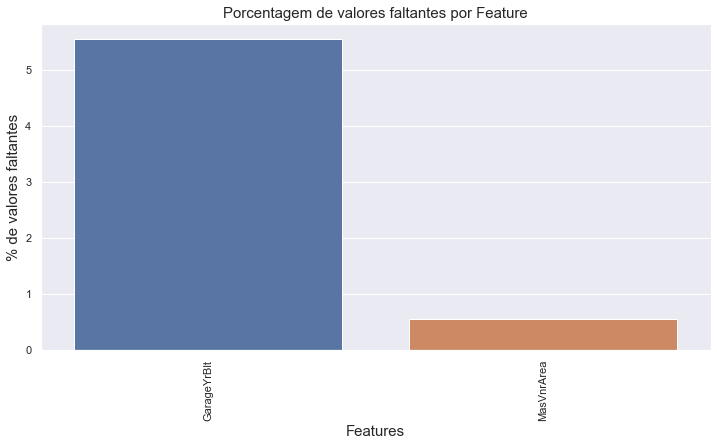

In [13]:
sns.barplot(x = dfPercentRelevant['Feature'], y = dfPercentRelevant['Faltantes %'])
plt.xticks(rotation = '90')
plt.xlabel('Features', fontsize = 15)
plt.ylabel('% de valores faltantes', fontsize = 15)
plt.title('Porcentagem de valores faltantes por Feature', fontsize = 15)

A maior porcentagem de valores faltantes equivale a 5% dos valores, uma quantidade não muito expressiva. Existem alguns modelos que podem ser utilizados para problemas de regressão que permitem valores não preenchidos, como, por exemplo, o *Random Forest*. Por enquanto, esses valores não preenchidos não causarão problemas.

In [14]:
updatedCorrelation = corrList

updatedCorrelation.append('SalePrice')

Com as correlações, pode-se ver melhor a forma em que cada categoria se relaciona com *SalePrice*. 

<function matplotlib.pyplot.show(close=None, block=None)>

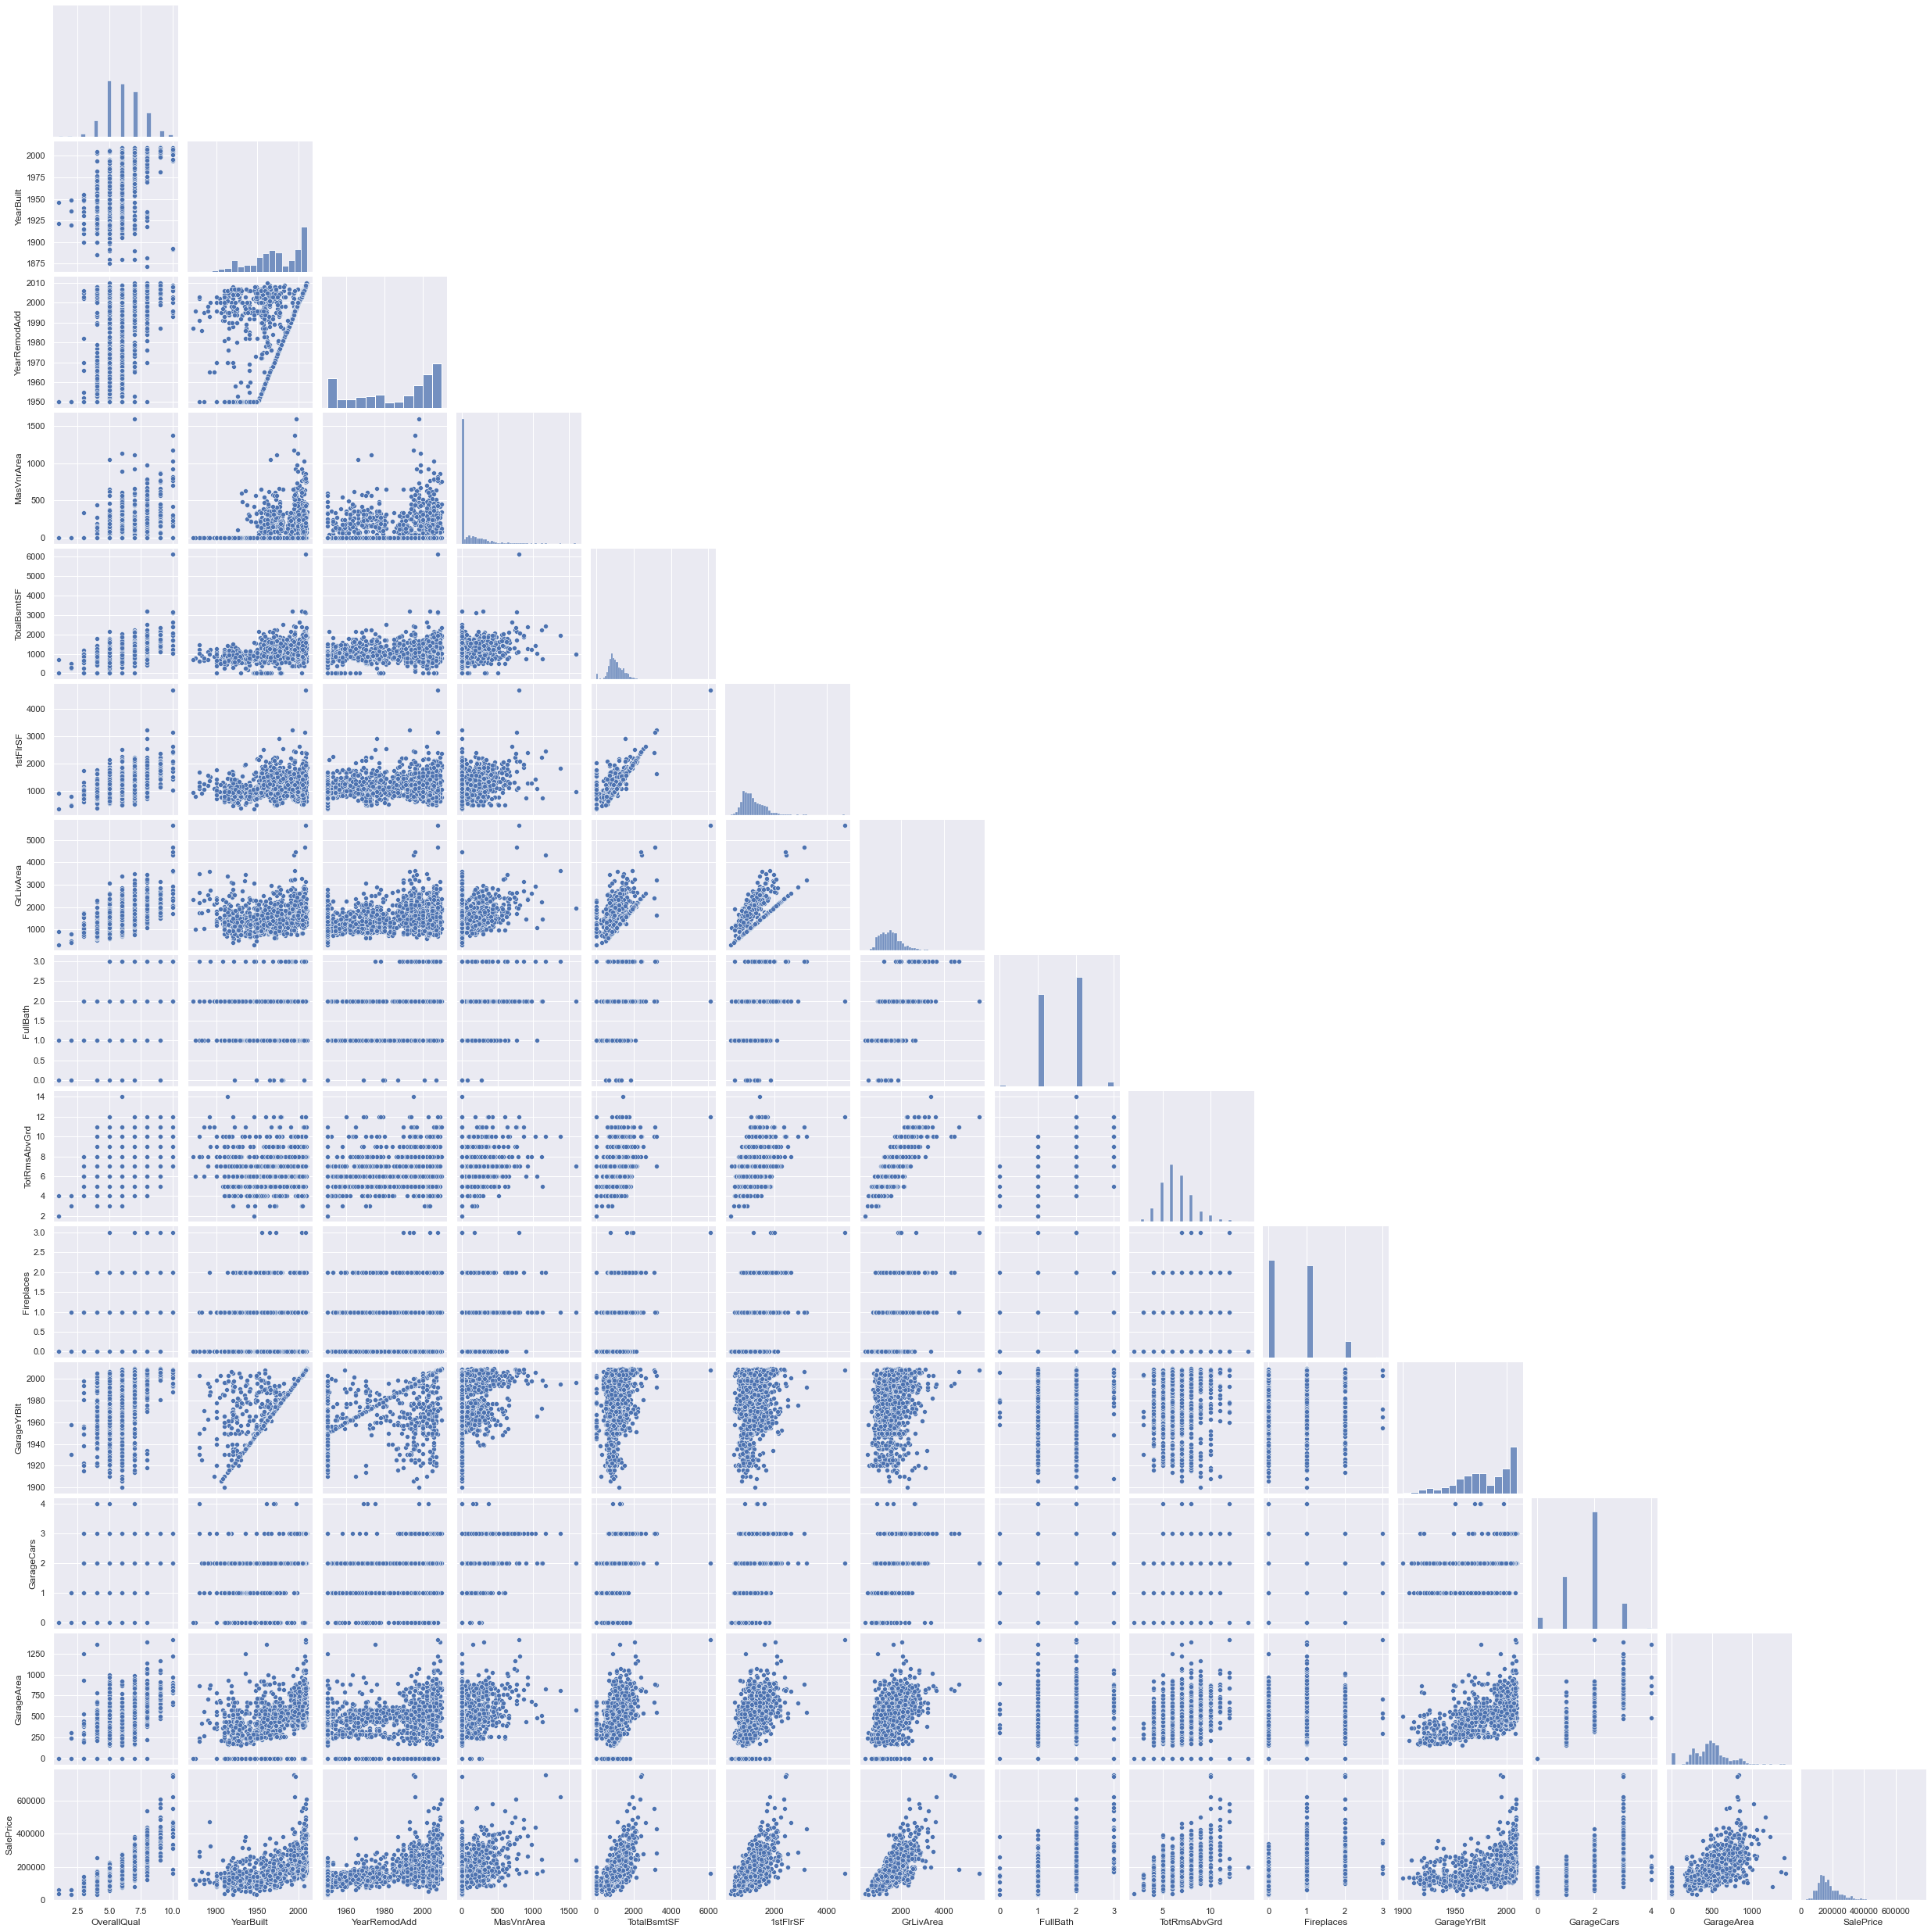

In [15]:
sns.set()

sns.pairplot(X[updatedCorrelation], height = 2.5, corner = True)

plt.show

Algumas categorias são interessantes de analisar: *1stFlrSF* se relaciona com *SalePrice* formando algo como uma exponencial, indicando que, quanto maior a área do primeiro andar, mais caro uma casa pode ser vendida, crescendo de maneira abrupta a partir de um valor. *GrLivArea* e *TotalBsmtSF* se comportam de maneira parecida. 

Já *YearBuilt*, *YearRemodAdd*, *GarageYrBlt* e *GarageArea* se comportam de maneira similar à uma fórmula linear, mantendo um crescimento constante em relação ao aumento do preço da casa. 

As *features* categóricas (*OverallQual*, *FullBath*, *TotRmsAbvGrd*, *Fireplaces* e *GarageCars*) tem um crescimento mais linear.

## Procurando por *outliers*

Baseando-se na análise feita dos gráficos relacionados à categoria *SalePrice* e a forma como os dados são exibidos entre si, pode-se analisar o quanto cada elemento do conjunto de dados é relevante para a construção do modelo regressor. 



### Análise univariada
Antes de analisarmos os dados comparando com *SalePrice*, um bom caminho a seguir é primeiro padronizar os dados desta coluna. Padronizando os dados, a média tende a 0, com um desvio padrão esperado de 1 (ou seja, variando entre -1 e 1).

In [16]:
saleprice_scaled = StandardScaler().fit_transform(np.array(X['SalePrice'])[:,np.newaxis])

low_range  = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


Valores em "low_range" indicam os primeiros 10 valores, sendo estes não tão longe de 0, indicando que não existem muitos valores como *outliers* menores que a média.

Valores em "high_range" são os 10 últimos em *SalePrice*, que variam até 7 ou mais, indicando uma **grande** variação. 

Agora, analisaremos os gráficos das *features* correlacionadas à *SalePrice*.


### Análise bivariada


#### Começando com os gráficos de *features* numéricas e analisado sua distribuição em relação à *SalePrice*.

Para criar os gráficos, as categorias numéricas serão ordenadas em relação à correlação com *SalePrice*. 

In [17]:
numFeatures = ['GrLivArea', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GarageYrBlt', 'GarageArea']

numValues = [corrDict[key] for key in numFeatures]

numValues.sort(reverse = True)

sortedNumFeatures = [key for key in sorted(corrDict, key = corrDict.get, reverse = True) if key in numFeatures]

[print('{}: {}'.format(sortedNumFeatures[i], '{:.2}'.format(numValues[i]))) for i in range(len(numFeatures))]

GrLivArea: 0.71
GarageArea: 0.62
TotalBsmtSF: 0.61
1stFlrSF: 0.61
YearBuilt: 0.52
GarageYrBlt: 0.49
MasVnrArea: 0.48


[None, None, None, None, None, None, None]

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

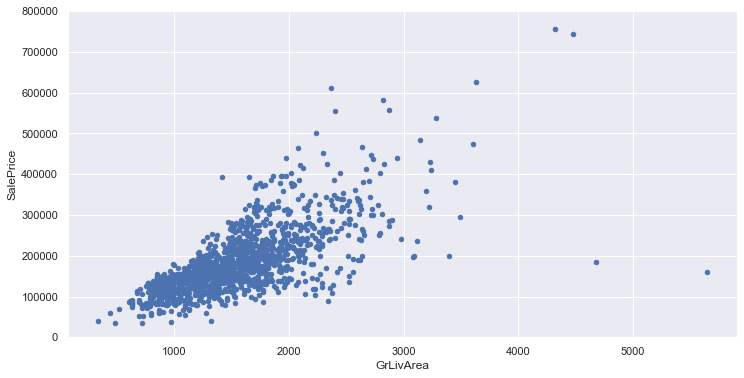

In [18]:
data = pd.concat([X['SalePrice'], X['GrLivArea']], axis=1)
data.plot.scatter(x = 'GrLivArea', y = 'SalePrice', c = '#4C72B0', ylim=(0,800000))

A representação dos elementos mais acima (com *SalePrice* > 700.000) são os elementos com a variação > 7. Estes elementos seguem o padrão que outros elementos representam, algo como uma função linear.

Já os elementos mais a esquerda (com *GrLivArea* > 4500) são elementos considerados *outliers*, sendo assim, removê-los é beneficial para o modelo regressor ter uma precisão maior.

In [19]:
#[X.drop(index = element, inplace = True) for element in range(len(X['GrLivArea'])) if X['GrLivArea'][element] >= 4500 and X['SalePrice'][element] < 200000]

for index in range(len(X['GrLivArea'])):
    if X['GrLivArea'][index] >= 4500 and X['SalePrice'][index] < 200000:
        X.drop(index = index, inplace = True)

Após esta remoção de elementos, os próximos gráficos se mantém dentro de um padrão, sem muitos *outliers*.

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

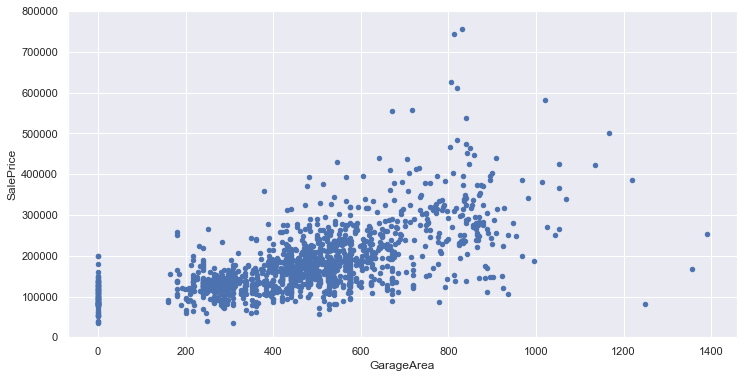

In [20]:
data = pd.concat([X['SalePrice'], X['GarageArea']], axis=1)
data.plot.scatter(x = 'GarageArea', y = 'SalePrice', c = '#4C72B0', ylim=(0, 800000))

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

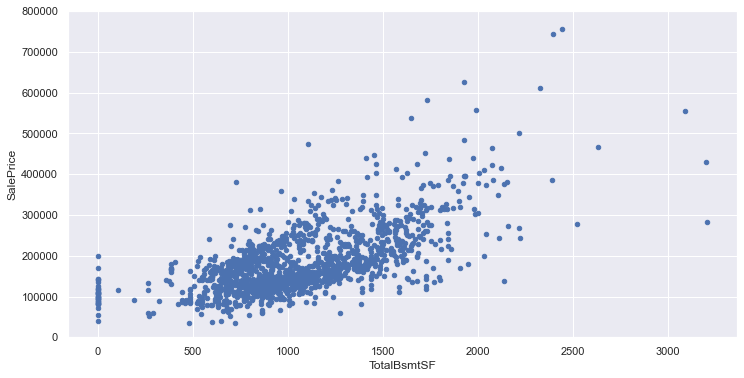

In [21]:
data = pd.concat([X['SalePrice'], X['TotalBsmtSF']], axis=1)
data.plot.scatter(x = 'TotalBsmtSF', y = 'SalePrice', c = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

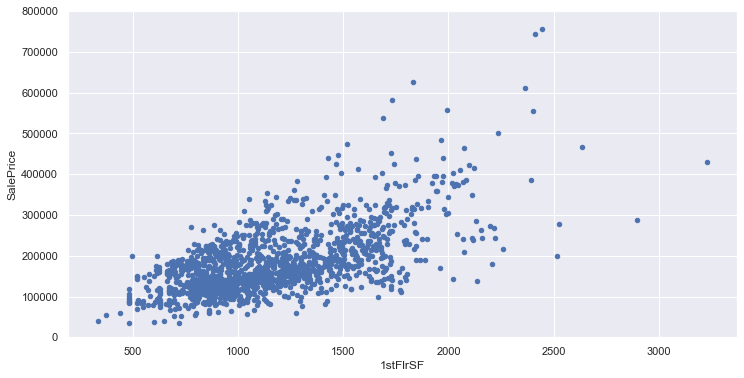

In [22]:
data = pd.concat([X['SalePrice'], X['1stFlrSF']], axis=1)
data.plot.scatter(x = '1stFlrSF', y = 'SalePrice', c = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

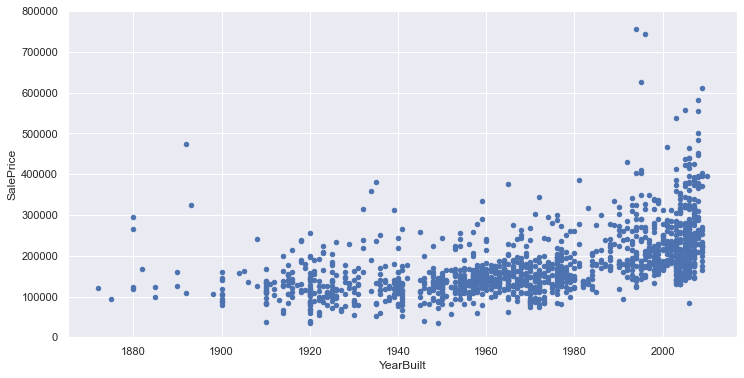

In [23]:
data = pd.concat([X['SalePrice'], X['YearBuilt']], axis=1)
data.plot.scatter(x = 'YearBuilt', y = 'SalePrice', c = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

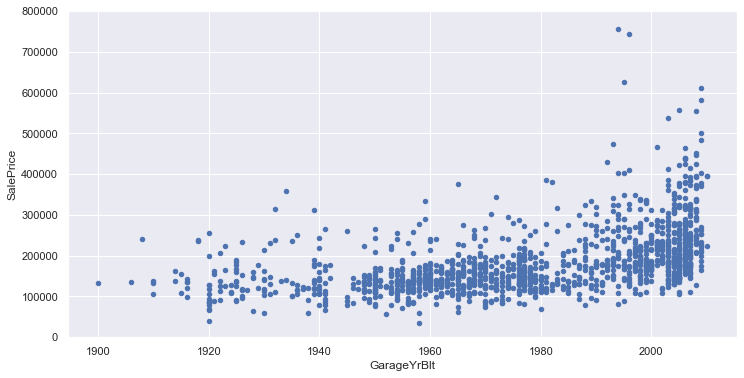

In [24]:
data = pd.concat([X['SalePrice'], X['GarageYrBlt']], axis=1)
data.plot.scatter(x = 'GarageYrBlt', y = 'SalePrice', c = '#4C72B0', ylim=(0,800000))

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

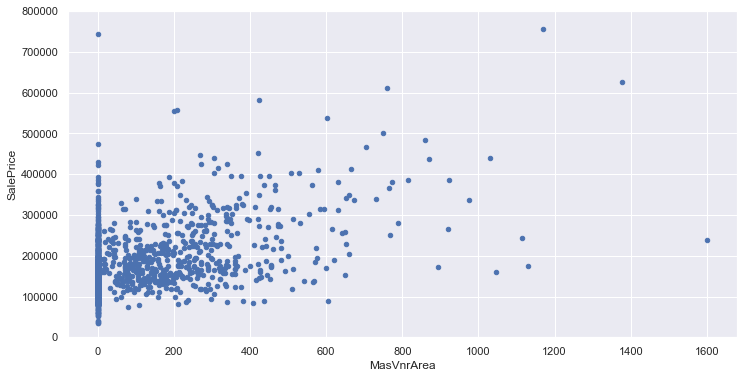

In [25]:
data = pd.concat([X['SalePrice'], X['MasVnrArea']], axis=1)
data.plot.scatter(x = 'MasVnrArea', y = 'SalePrice', c = '#4C72B0', ylim=(0,800000))

#### Continuando com os gráficos de *features* categóricas.

In [26]:
catFeatures = ['OverallQual', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']

catValues = [corrDict[key] for key in catFeatures]

catValues.sort(reverse = True)

sortedCatFeatures = [key for key in sorted(corrDict, key = corrDict.get, reverse = True) if key in catFeatures]

[print('{}: {}'.format(sortedCatFeatures[i], "{:.2}".format(catValues[i]))) for i in range(len(catFeatures))]

OverallQual: 0.79
FullBath: 0.56
TotRmsAbvGrd: 0.53
Fireplaces: 0.47


[None, None, None, None]

Com o diagrama de caixa, podemos ver melhor as *features* categóricas e seus *outliers* de maneira mais clara. Em cada *feature*, pode-se ver que praticamente todas têm um ou mais *outliers*. Para melhorar a precisão do regressor, deve-se analisar caso a caso, a fim de decidir entre removê-los, se fugirem muito do padrão, ou mantê-los, caso sigam a ideia do conjunto de dados.

(-0.5, 9.5, 0.0, 800000.0)

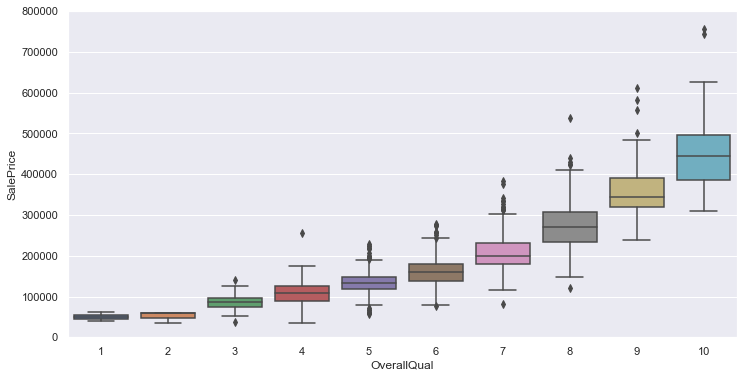

In [27]:
data = pd.concat([X['SalePrice'], X['OverallQual']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 3.5, 0.0, 800000.0)

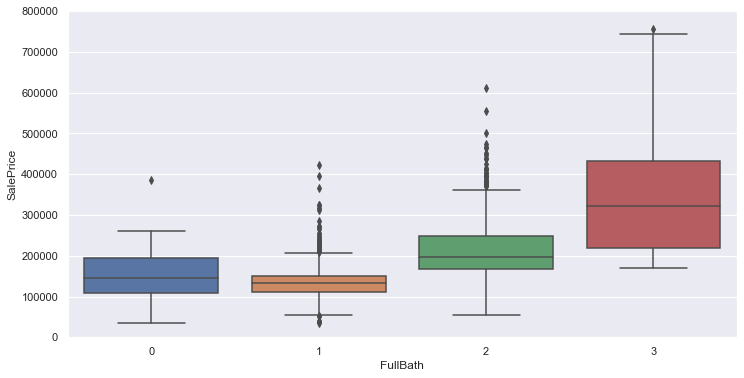

In [28]:
data = pd.concat([X['SalePrice'], X['FullBath']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'FullBath', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 11.5, 0.0, 800000.0)

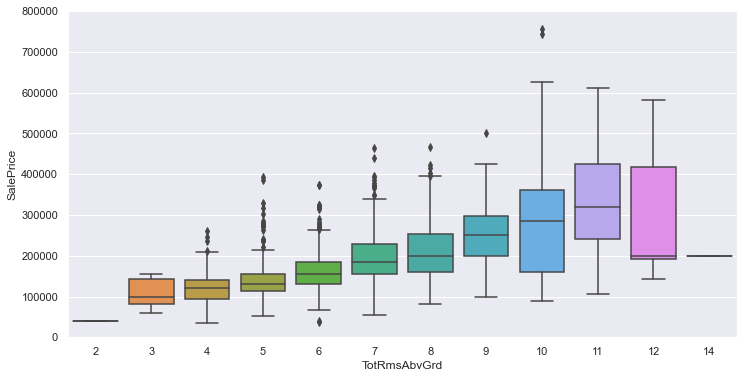

In [29]:
data = pd.concat([X['SalePrice'], X['TotRmsAbvGrd']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 3.5, 0.0, 800000.0)

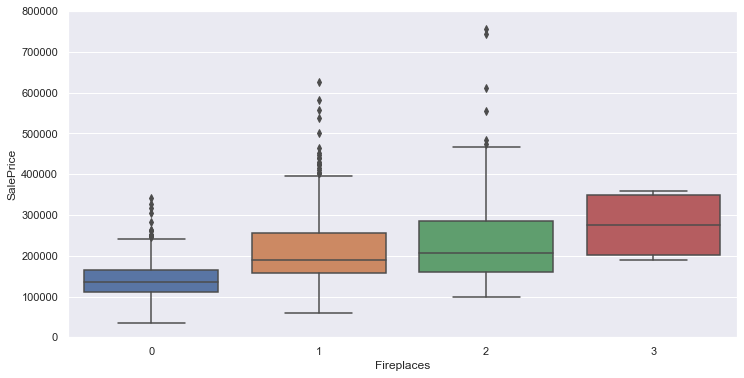

In [30]:
data = pd.concat([X['SalePrice'], X['Fireplaces']], axis=1)
f, ax = plt.subplots()
fig = sns.boxplot(x = 'Fireplaces', y = 'SalePrice', data = data)
fig.axis(ymin=0, ymax=800000)

## Análise mais detalhada de das *features*


### Criando gráficos das *features* para checar a distribuição
Com o histograma e o gráfico de probabilidade dos dados gerado, é possível analisar melhor o formato das *features*. 

#### *SalePrice*

Nota-se, no histograma, que a distribuição dos mesmos foge da distribuição normal, tendo uma assimetria positiva, indicando que existem mais elementos maiores que o pico da função de distribuição. O valor positivo da curtose indica uma curva leptocúrtica, que representa o quão fácil é encontrar elementos do *dataset* que fogem da média.

Assimetria: 1.8812964895244009
Curtose: 6.523066888485879


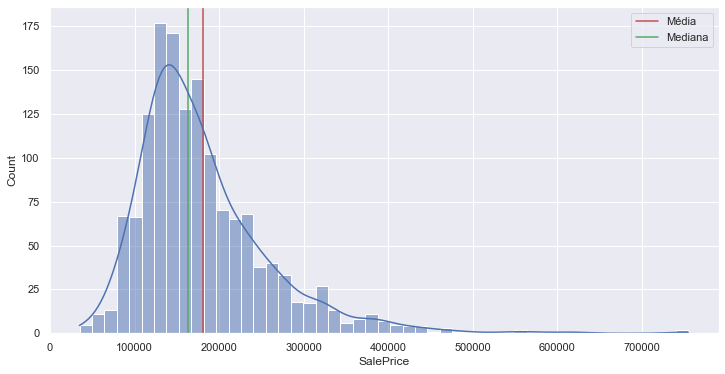

In [31]:
createHistPlot(X['SalePrice'])

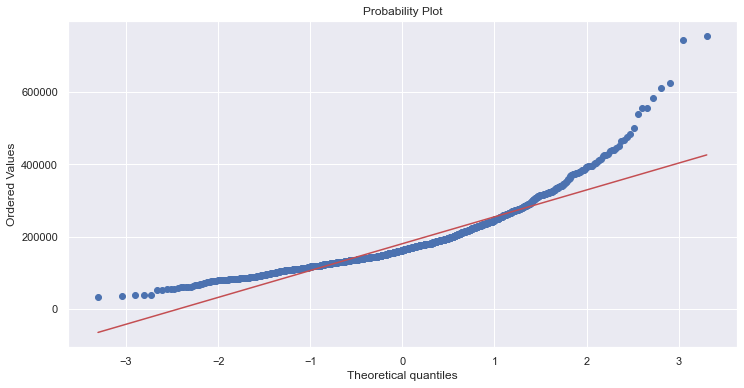

In [32]:
createProbPlot(X['SalePrice'])

Como dito anteriormente, assimetria > 0 indica que o a *feature*-alvo *SalePrice* precisa ser normalizada.

In [33]:
X['SalePrice'] = np.log(X['SalePrice'])

Assimetria: 0.12156821443518166
Curtose: 0.8047636129011364


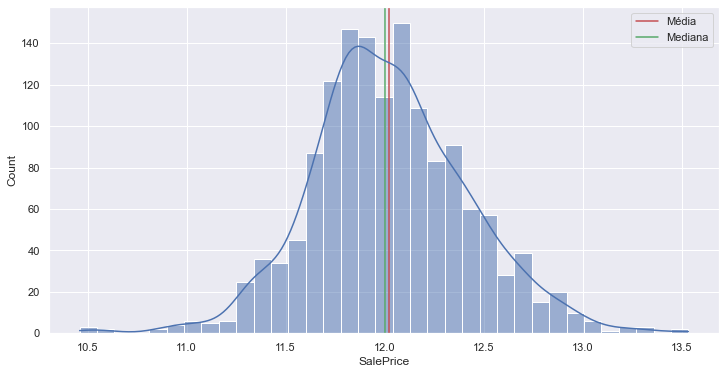

In [34]:
createHistPlot(X['SalePrice'])

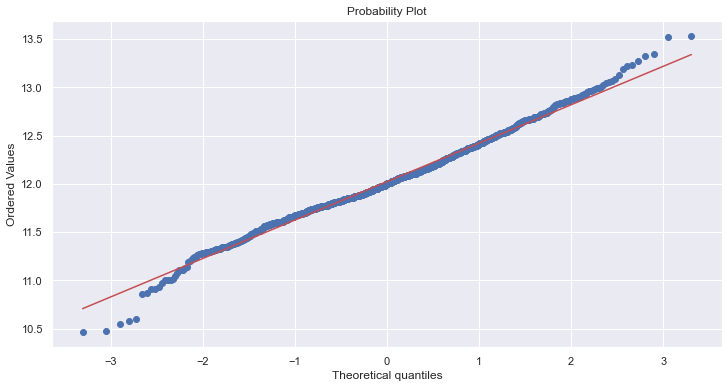

In [35]:
createProbPlot(X['SalePrice'])

#### Outras *features*

Dado que *SalePrice* não estava distribuido normalmente, deve-se checar as outras *features* e normalizá-las, caso necessário. 

##### *GrLivArea*


Assimetria: 1.0109917025385513
Curtose: 2.063463404376057


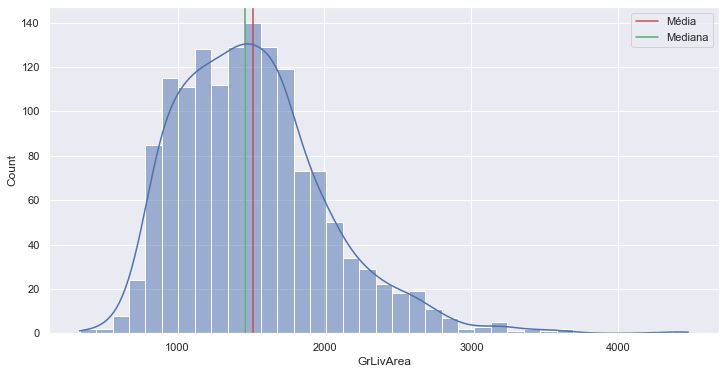

In [36]:
createHistPlot(X['GrLivArea'])

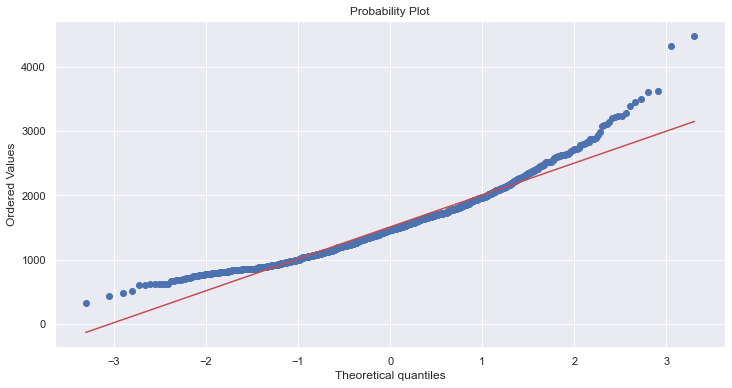

In [37]:
createProbPlot(X['GrLivArea'])

Como em *SalePrice*, é aplicado a transformação nos dados.

In [38]:
X['GrLivArea'] = np.log(X['GrLivArea'])

Assimetria: -0.07181927264805592
Curtose: 0.09633059538035882


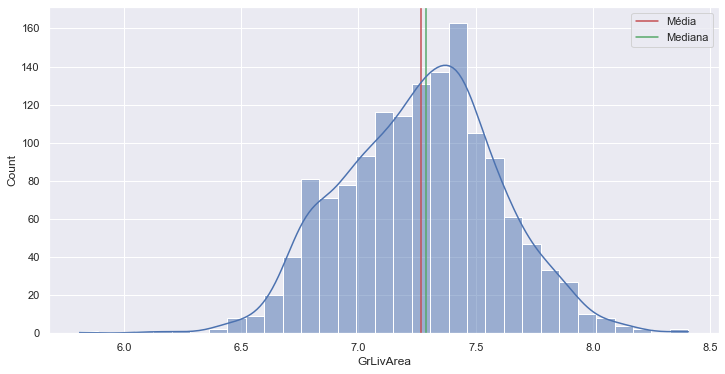

In [39]:
createHistPlot(X['GrLivArea'])

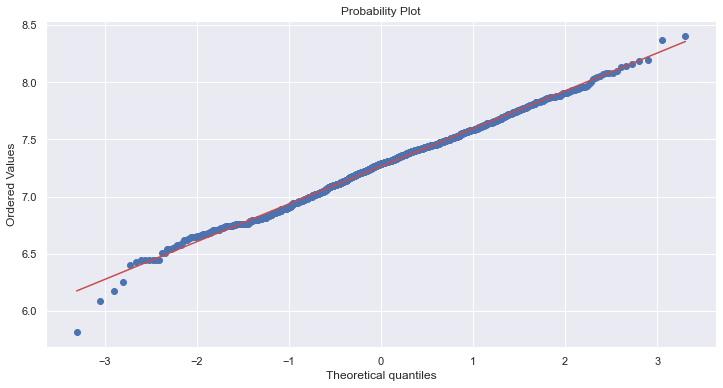

In [40]:
createProbPlot(X['GrLivArea'])

##### *GarageArea*

Assimetria: 0.13174798037584048
Curtose: 0.7612933596511593


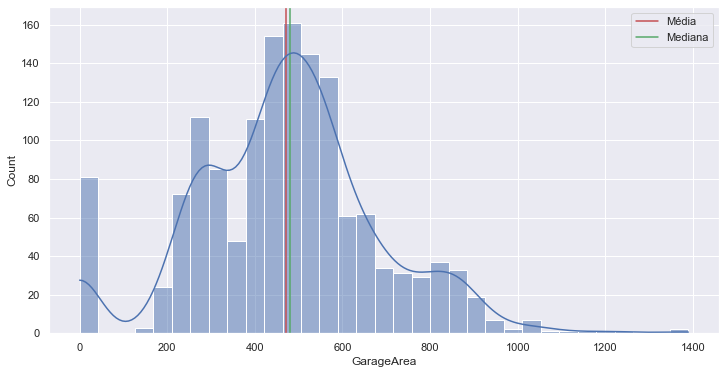

In [41]:
createHistPlot(X['GarageArea'])

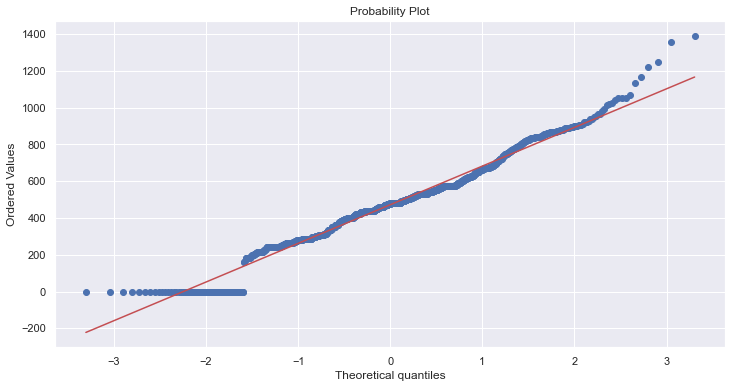

In [42]:
createProbPlot(X['GarageArea'])

Um problema encontrado: uma grande quantidade de elementos com valor igual a 0, representando uma casa sem garagem (área de garagem = 0). A transformação utilizando log não pode ser executada com valores iguais a 0, então, é preciso improvisar.

É então, adicionado uma nova coluna no *dataset*, indicando quais elementos do mesmo possuem garagem: se a área da garagem é maior que 0, o elemento possui garagem, senão, não possui.

In [43]:
X['HasGarage'] = pd.Series(len(X['GarageArea']), index=X.index)
X['HasGarage'] = 0 
X.loc[X['GarageArea'] > 0,'HasGarage'] = 1

É, então, feito a transformação linear nos elementos que possuem garagem.

In [44]:
X.loc[X['GarageArea'] == 1,'GarageArea'] = np.log(X['GarageArea'])

C:\Users\bielx\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
lista = X[X['GarageArea'] > 0 ]['GarageArea']

Assimetria: 0.7549353141457075
Curtose: 0.9132982002968588


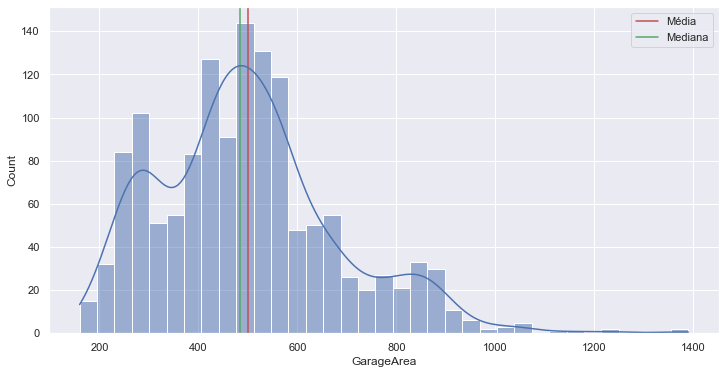

In [46]:
createHistPlot(lista)

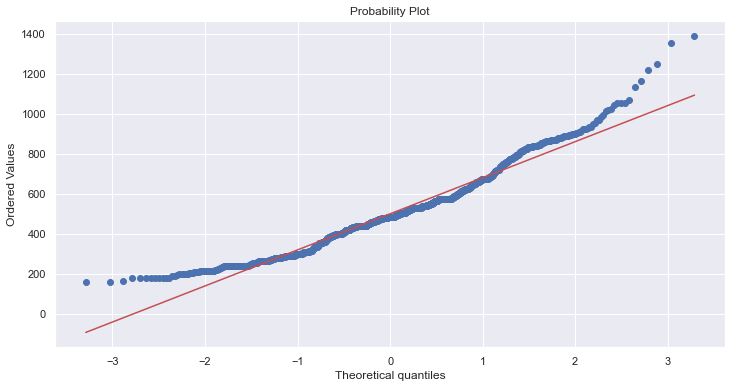

In [47]:
createProbPlot(lista)

O resultado não é dos melhores, mas é o que foi possível obter.

##### *TotalBsmtSF*

Assimetria: 0.5117033418828824
Curtose: 1.7701050712157982


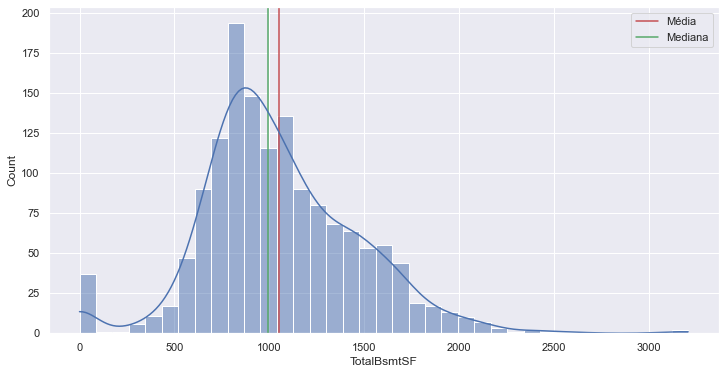

In [48]:
createHistPlot(X['TotalBsmtSF'])

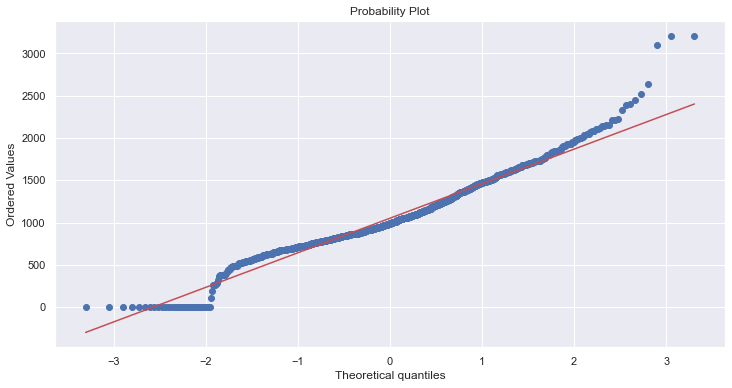

In [49]:
createProbPlot(X['TotalBsmtSF'])

Nessa *feature*, podemos ver que existem elementos com valor igual a 0, logo, é necessário fazer o mesmo processo realizado na *feature* anterior.

In [50]:
X['HasBsmt'] = pd.Series(len(X['TotalBsmtSF']), index=X.index)
X['HasBsmt'] = 0 
X.loc[X['TotalBsmtSF'] > 0,'HasBsmt'] = 1

In [51]:
X.loc[X['TotalBsmtSF'] == 1,'TotalBsmtSF'] = np.log(X['TotalBsmtSF'])

C:\Users\bielx\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
lista = X[X['TotalBsmtSF'] > 0 ]['TotalBsmtSF']

Assimetria: 0.9895639898995955
Curtose: 1.9139117344923084


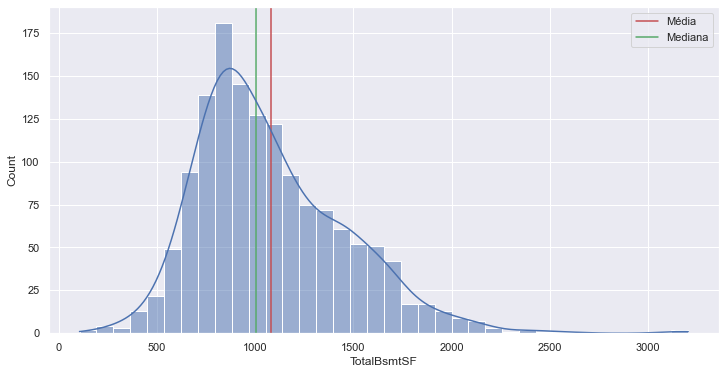

In [53]:
createHistPlot(lista)

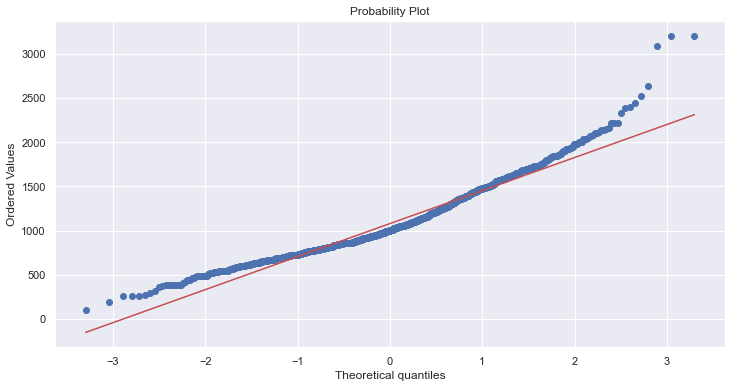

In [54]:
createProbPlot(lista)

##### *1stFlrSF*

Assimetria: 0.887636603215269
Curtose: 1.1173853273180527


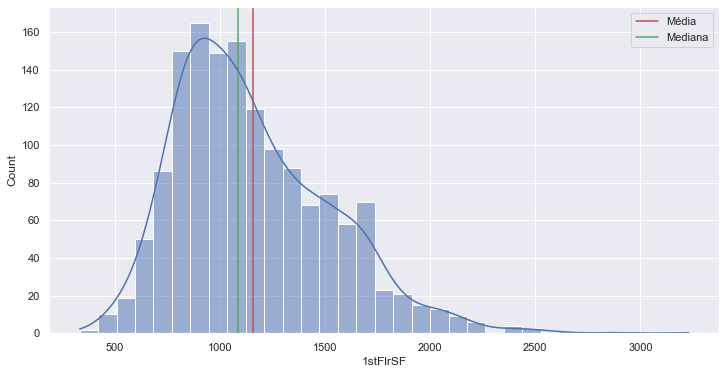

In [55]:
createHistPlot(X['1stFlrSF'])

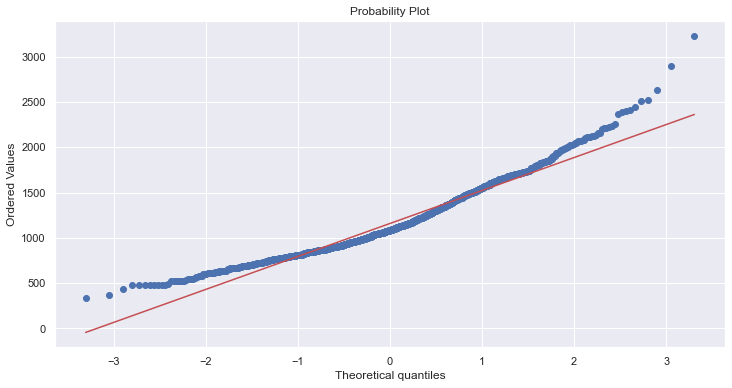

In [56]:
createProbPlot(X['1stFlrSF'])

Com a assimetria e a curtose se distanciando de 0, aplica-se a transformação.

In [57]:
X['1stFlrSF'] = np.log(X['1stFlrSF'])

Assimetria: 0.006100763432043236
Curtose: -0.10439937060542359


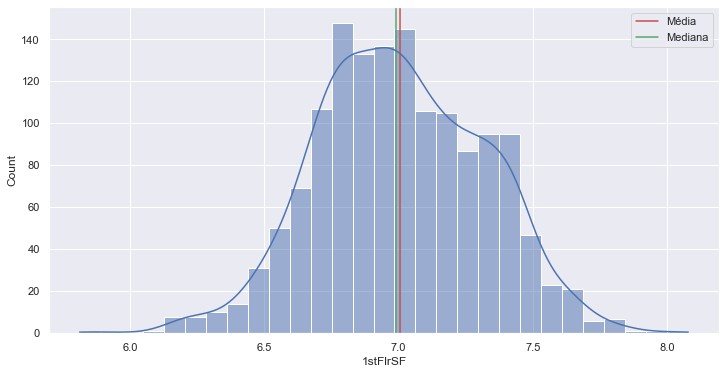

In [58]:
createHistPlot(X['1stFlrSF'])

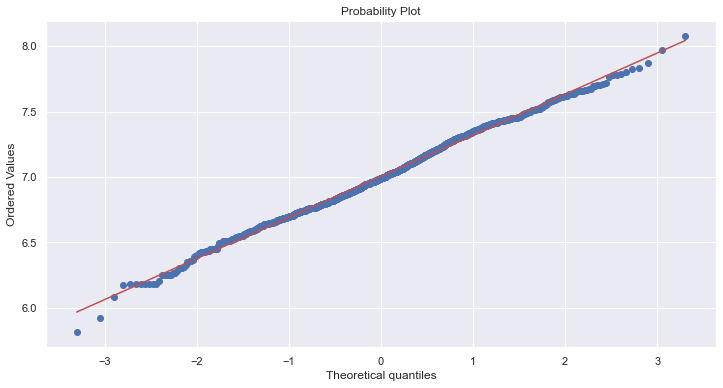

In [59]:
createProbPlot(X['1stFlrSF'])

##### *YearBuilt*

Assimetria: -0.6122946245971633
Curtose: -0.43982598970964215


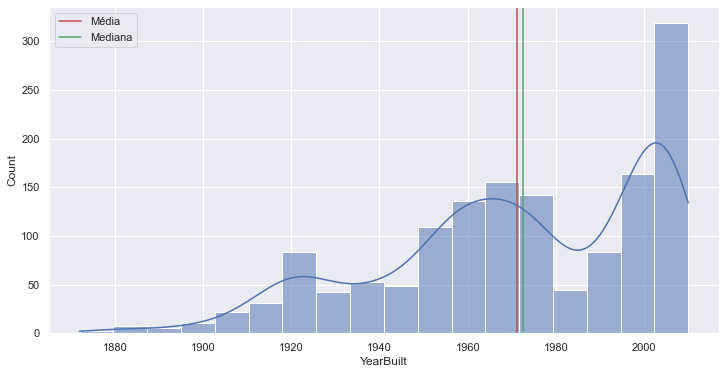

In [60]:
createHistPlot(X['YearBuilt'])

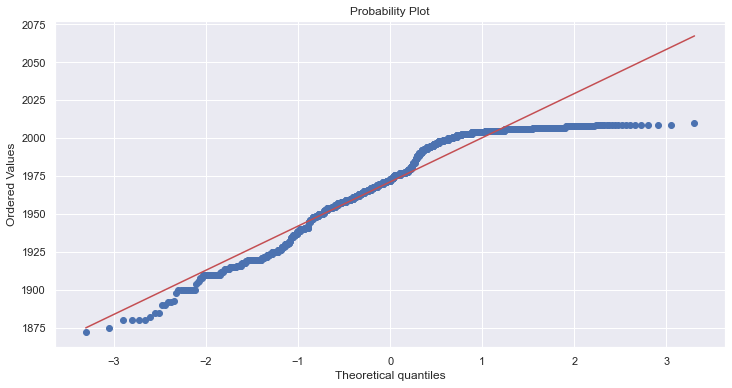

In [61]:
createProbPlot(X['YearBuilt'])

Apesar da aparência do gráfico, a assimetria e a curtose estão relativamente próximas do ideal valor 0, indicando que, talvez, realizar a transformação dos dados não traga um ganho.

##### *GarageYrBlt*

Assimetria: -0.6481367521644216
Curtose: -0.4189334729621188


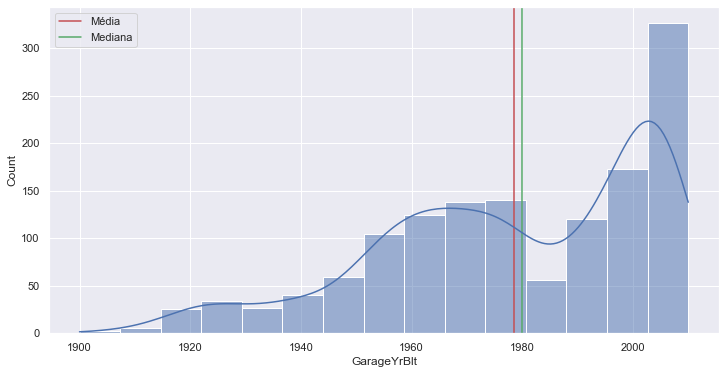

In [62]:
createHistPlot(X['GarageYrBlt'])

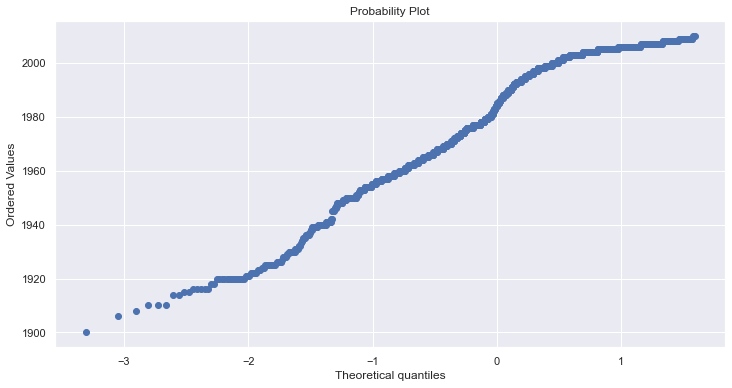

In [63]:
createProbPlot(X['GarageYrBlt'])

Assim como a *feature YearBuilt*, *GarageYrBlt* não tem uma assimetria e curtose longe de 0, e, com uma transformação, o resultado não deve melhorar.

##### *MasVnrArea*

Assimetria: 2.6877840195436478
Curtose: 10.358239894207099


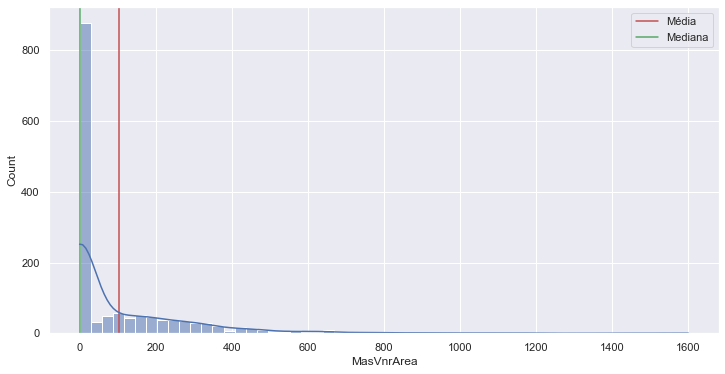

In [64]:
createHistPlot(X['MasVnrArea'])

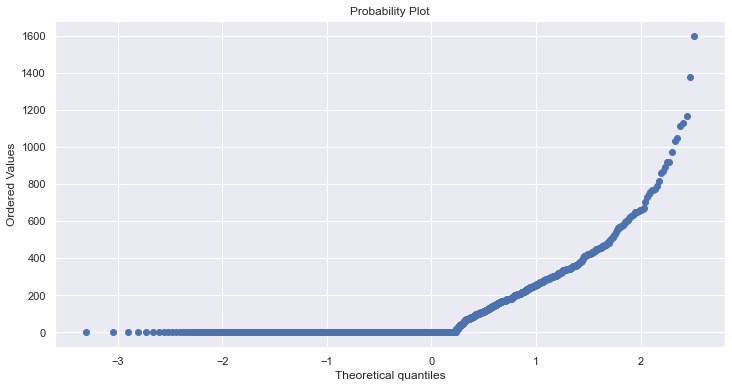

In [65]:
createProbPlot(X['MasVnrArea'])

Dado a grande ocorrência de 0 nessa *feature*, tentar transformar para melhorar a distribuição não vai melhorar o resultado.

## Por fim, é gerado as variáveis *dummy*

In [66]:
X = pd.get_dummies(X)

## Agora, finalmente, os dados estão prontos para serem utilizados por um algoritmo regressor.